In [1]:
import numpy as np
import math
import os,glob
import pandas as pd
from pylab import *
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap,shiftgrid
import matplotlib.cm as cm
from scipy.stats import f as scist
import scipy.io

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
% matplotlib inline

In [2]:
# initialize key parameters
nc_filename=['/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/S_ANHA4-ENG3_6h_19580101_19580101_ptrc_T.nc']
ptrc=nc.Dataset(nc_filename[0])


lon=ptrc.variables['nav_lon'][:,:]
lat=ptrc.variables['nav_lat'][:,:]
dep = ptrc.variables['deptht'][:]


tmask=nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
mbathy=tmask.variables['mbathy'][0,400:,:]
tmask=tmask.variables['tmask'][0,:,400:,:]


bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

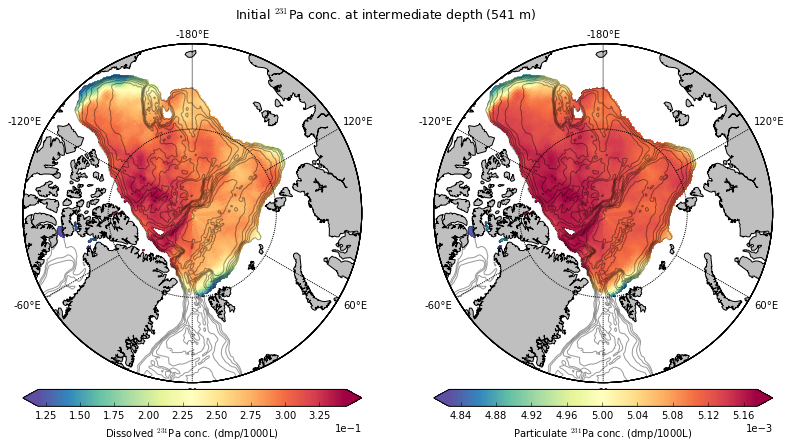

In [50]:
# IC for diss/part Pa

layer= 31
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13.5,6.5))
nclist=['/ocean/xiaoxiny/research/data/init_files/anazero_ANHA_Pa_diss.nc',\
             '/ocean/xiaoxiny/research/data/init_files/anazero_ANHA_Pa_part.nc']
for ax,time,nc_filename,string,title in \
zip(axes.flat,[0,0], nclist,['Pa_diss','Pa_part'],['Dissolved $^{231}$Pa','Particulate $^{231}$Pa']):
    ptrc=nc.Dataset(nc_filename)
    data =ptrc.variables[string][time,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    data[:,:125,:]=np.ma.masked
    
    m = Basemap(projection='npstere',boundinglat=70,lon_0=0,resolution='l',round=True, ax=ax)
    m.drawcoastlines()
    m.fillcontinents(color = '0.75')
    m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0, 0, 1, 1])
    x_lon,y_lat = m(lon,lat)
    # pcolor
    cs=m.pcolor(x_lon,y_lat,data[layer,:,:],cmap='Spectral_r'); 
    cbar=m.colorbar(cs,location='bottom',extend='both')
    cbar.set_label('%s conc. (dmp/1000L)'%(title))
    cbar.formatter.set_powerlimits((-1, 1))
    cbar.update_ticks()
    # bathy
    m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.4)

fig.suptitle('Initial $^{231}$Pa conc. at intermediate depth (%.0f m)'%(dep[layer]),fontsize=12.5)
# Make an axis for the colorbar on the right side
#cax = fig.add_axes([0.3, 0.05, 0.4, 0.04])
#cbar=fig.colorbar(cs, orientation='horizontal',cax=cax)
#cbar.set_label('tracer conc. (dpm/1000kg)')

plt.show()

0.194354 0.584103
0.0502389 0.0731207


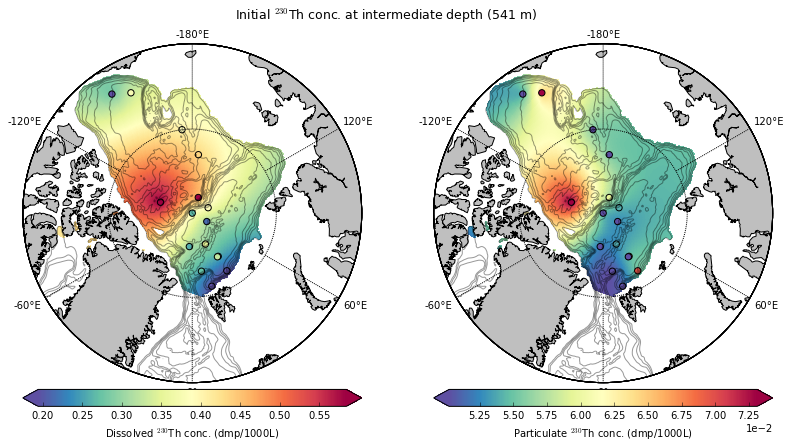

In [98]:
# IC for diss/part Th

layer= 31
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13.5,6.5))
nclist=['/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Th_diss.nc',\
             '/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Th_part.nc']
for ax,time,nc_filename,string,title in \
zip(axes.flat,[0,0], nclist,['Th_diss','Th_part'],['Dissolved $^{230}$Th','Particulate $^{230}$Th']):
    ptrc=nc.Dataset(nc_filename)
    data =ptrc.variables[string][time,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    data[:,:125,:]=np.ma.masked
    
    if string == 'Th_diss':
        obs_data=scipy.io.loadmat('/ocean/xiaoxiny/research/analysis/Cindy Yu/ANHA_initial/ANHA4_Th_diss.mat')
        lons=obs_data['lons']
        lats=obs_data['lats']
        obs=obs_data['Th_diss']
    else:
        obs_data=scipy.io.loadmat('/ocean/xiaoxiny/research/analysis/Cindy Yu/ANHA_initial/ANHA4_Th_part.mat')
        lons=obs_data['lons']
        lats=obs_data['lats']
        obs=obs_data['Th_part']
        
    m = Basemap(projection='npstere',boundinglat=70,lon_0=0,resolution='l',round=True, ax=ax)
    m.drawcoastlines()
    m.fillcontinents(color = '0.75')
    m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0, 0, 1, 1])
    x_lon,y_lat = m(lon,lat)
    # pcolor
    cs=m.pcolor(x_lon,y_lat,data[layer,:,:],cmap='Spectral_r'); 
    
    cbar=m.colorbar(cs,location='bottom',extend='both')
    vmin, vmax =cbar.get_clim()
    
    cbar.set_label('%s conc. (dmp/1000L)'%(title))
    cbar.formatter.set_powerlimits((-2, 1))
    cbar.update_ticks()
    # bathy
    m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.4)
    
    # prepare obs data
    x=lons[layer,:]
    y=lats[layer,:]
    z=obs[layer,:]

    z_ma=np.ma.masked_where(z<= 1e-200,z)
    z_ma=np.ma.masked_where(np.isnan(z_ma),z_ma)
    x_ma=np.ma.masked_where(np.isnan(z_ma),x)
    y_ma=np.ma.masked_where(np.isnan(z_ma),y)

    x_ma=x_ma.compressed()
    y_ma=y_ma.compressed()
    z_ma=z_ma.compressed()
    
    # scatter obs data
    x_dis,y_dis = m(x_ma, y_ma)
    cmm = plt.cm.get_cmap('Spectral_r')
    m.scatter(x_dis,y_dis,c=np.array(z_ma),\
      vmin=vmin,vmax=vmax,cmap=cmm,s=40)
        

fig.suptitle('Initial $^{230}$Th conc. at intermediate depth (%.0f m)'%(dep[layer]),fontsize=12.5)